# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ]. 

# Step 1: Prepare the environment 

Use one of the labs which we have practised on with the Amazon Sagemakers where you perform the following steps:
1. Start a lab.
2. Create a notebook instance and name it "oncloudproject".
3. Increase the used memory to 25 GB from the additional configurations.
4. Open Jupyter Lab and upload this notebook into it.
5. Upload the two combined CVS files (combined_csv_v1.csv and combined_csv_v2.csv), which you created in Part A of this project.

In [1]:
# Libraries.
import io
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator

RANDOM_STATE = 0

In [2]:
# Function to import csv

def import_csv(filename):
    """
    Import csv into train, test, and validation.
    """
    df = pd.read_csv(filename)
    df_train, df_test = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE, stratify=df['target'])
    df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=RANDOM_STATE, stratify=df_test['target'])
    return df_train, df_test, df_val

In [3]:
# Import the first dataset.
df_train_v1, df_test_v1, df_val_v1 = import_csv('combined_csv_v1.csv')

# Check sizes.
print(f'Train dataframe: {df_train_v1.shape}')
print(f'Test dataframe: {df_test_v1.shape}')
print(f'Val dataframe: {df_val_v1.shape}')

Train dataframe: (1144913, 94)
Test dataframe: (245338, 94)
Val dataframe: (245339, 94)


In [4]:
# Save to csv format.
df_train_v1.to_csv('train_v1.csv', index=False, header=False)
df_test_v1.to_csv('test_v1.csv', index=False, header=False)
df_val_v1.to_csv('val_v1.csv', index=False, header=False)

In [5]:
# Import the second dataset.
df_train_v2, df_test_v2, df_val_v2 = import_csv('combined_csv_v2.csv')

# Check sizes
print(f'Train dataframe: {df_train_v2.shape}')
print(f'Test dataframe: {df_test_v2.shape}')
print(f'Val dataframe: {df_val_v2.shape}')

Train dataframe: (1144913, 86)
Test dataframe: (245338, 86)
Val dataframe: (245339, 86)


In [6]:
# Save to csv format.
df_train_v2.to_csv('train_v2.csv', index=False, header=False)
df_test_v2.to_csv('test_v2.csv', index=False, header=False)
df_val_v2.to_csv('val_v2.csv', index=False, header=False)

In [7]:
# Get y_trues.
y_true_v1 = df_test_v1['target'].to_numpy()
y_true_v2 = df_test_v2['target'].to_numpy()

In [8]:
# Process S3 bucket.
session = sagemaker.Session()
bucket = session.default_bucket()

# Get region.
region = boto3.Session().region_name 

# Get the execution role.
role = sagemaker.get_execution_role()

# Get client.
s3 = boto3.client('s3')

# Prefix.
prefix = 'dsts-final-assignment'

# Upload the first data to csv bucket.
train_v1_path = session.upload_data(path='train_v1.csv', key_prefix=prefix + '/input/training')
test_v1_path = session.upload_data(path='test_v1.csv', key_prefix=prefix + '/input/testing')
val_v1_path = session.upload_data(path='val_v1.csv', key_prefix=prefix + '/input/validation')

# Print the S3 paths.
print(f'Training V1: {train_v1_path}')
print(f'Testing V1: {test_v1_path}')
print(f'Validation V1: {val_v1_path}')

# Upload the second data to csv bucket.
train_v2_path = session.upload_data(path='train_v2.csv', key_prefix=prefix + '/input/training')
test_v2_path = session.upload_data(path='test_v2.csv', key_prefix=prefix + '/input/testing')
val_v2_path = session.upload_data(path='val_v2.csv', key_prefix=prefix + '/input/validation')

# Print the S3 paths.
print(f'Training V2: {train_v2_path}')
print(f'Testing V2: {test_v2_path}')
print(f'Validation V2: {val_v2_path}')

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


Training V1: s3://sagemaker-us-east-1-669452603953/dsts-final-assignment/input/training/train_v1.csv
Testing V1: s3://sagemaker-us-east-1-669452603953/dsts-final-assignment/input/testing/test_v1.csv
Validation V1: s3://sagemaker-us-east-1-669452603953/dsts-final-assignment/input/validation/val_v1.csv
Training V2: s3://sagemaker-us-east-1-669452603953/dsts-final-assignment/input/training/train_v2.csv
Testing V2: s3://sagemaker-us-east-1-669452603953/dsts-final-assignment/input/testing/test_v2.csv
Validation V2: s3://sagemaker-us-east-1-669452603953/dsts-final-assignment/input/validation/val_v2.csv


In [9]:
# Training channels.

# Create V1 channels.
train_channel_v1 = sagemaker.TrainingInput(s3_data=train_v1_path, content_type='text/csv')
val_channel_v1 = sagemaker.TrainingInput(s3_data=val_v1_path, content_type='text/csv')

# Put in dictionary.
channels_v1 = {
    'train' : train_channel_v1,
    'validation' : val_channel_v1
}

# Create V2 channels.
train_channel_v2 = sagemaker.TrainingInput(s3_data=train_v2_path, content_type='text/csv')
val_channel_v2 = sagemaker.TrainingInput(s3_data=val_v2_path, content_type='text/csv')

# Put in dictionary.
channels_v2 = {
    'train' : train_channel_v2,
    'validation' : val_channel_v2
}

In [10]:
# Upload testing X data V1 to S3 bucket.
X_test_v1 = df_test_v1.iloc[:, 1:]
X_test_v1.to_csv('batch_v1.csv', index=False, header=False)
X_test_v1_path = session.upload_data(path='batch_v1.csv', key_prefix=prefix + '/input/testing')

# Print the X_test path.
print(f'X data V1 path: {X_test_v1_path}')

# Upload testing X data V2 to S3 bucket.
X_test_v2 = df_test_v2.iloc[:, 1:]
X_test_v2.to_csv('batch_v2.csv', index=False, header=False)
X_test_v2_path = session.upload_data(path='batch_v2.csv', key_prefix=prefix + '/input/testing')

# Print the X_test path.
print(f'X data V2 path: {X_test_v1_path}')

X data V1 path: s3://sagemaker-us-east-1-669452603953/dsts-final-assignment/input/testing/batch_v1.csv
X data V2 path: s3://sagemaker-us-east-1-669452603953/dsts-final-assignment/input/testing/batch_v1.csv


In [11]:
# Collections from the onpremise part.

def plot_confusion_matrix(test_labels, target_predicted, labels=['Non-delayed', 'Delayed'], title='Confusion Matrix'):
    # complete the code here
    # Create confusion matrix.
    cm = confusion_matrix(test_labels, target_predicted)
    # Plot heatmap.
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.4%', cmap='Blues', xticklabels=labels, yticklabels=labels)
    # Set labels.
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

def result_summary(test_labels, target_predicted, header=None):
    if (header is not None):
        print(f'{str(header)}')
        print('=' * 20)
    accuracy = accuracy_score(test_labels, target_predicted)
    f1_score_binary = f1_score(test_labels, target_predicted)
    print(f'Accuracy: {accuracy}')
    print(f'f1 score: {f1_score_binary}')
    print(classification_report(test_labels, target_predicted))

# Step 2: Build and evaluate simple models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use linear learner estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 

Note: You are required to perform the above steps on the two combined datasets separatey and to comments on the difference.

In [12]:
# Collections for step 2.

# Get linear learner.
ll_container = retrieve(framework='linear-learner', region=region)

# Path for batch outputs.
batch_output_path_ll = 's3://{}/{}/batch_out_ll/'.format(bucket, prefix)
print(f'Batch output path: {batch_output_path_ll}')

# Turn to numpy.
def get_ll_prediction(pd_series):
    return np.array([int(prediction[-1]) for prediction in pd_series.index])

Batch output path: s3://sagemaker-us-east-1-669452603953/dsts-final-assignment/batch_out_ll/


### combined_csv_v1.csv

In [13]:
# Create classifier for data v1.
clf_ll_v1 = Estimator(
    ll_container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path='s3://{}/{}/output'.format(bucket, prefix)
)

# Set hyperparameters.
clf_ll_v1.set_hyperparameters(
    predictor_type='binary_classifier',
    mini_batch_size=10_000,
    epochs=3
)

In [14]:
# Train linear-learner for v1 dataset.
clf_ll_v1.fit(channels_v1)

2022-11-03 16:39:53 Starting - Starting the training job...
2022-11-03 16:40:17 Starting - Preparing the instances for trainingProfilerReport-1667493593: InProgress
.........
2022-11-03 16:41:54 Downloading - Downloading input data...
2022-11-03 16:42:21 Training - Downloading the training image......
2022-11-03 16:43:17 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/03/2022 16:43:14 INFO 139656417150784] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias

In [15]:
# Batch transform for linear learner on v1 dataset.

# Instantiate the transformer.
# Host the model on another instance.
transformer_ll_v1 = clf_ll_v1.transformer(
    instance_count=1,
    instance_type='ml.c5.9xlarge',
    strategy='MultiRecord',
    assemble_with='Line',
    output_path=batch_output_path_ll
)

# Perform batch transform on the testing data.
transformer_ll_v1.transform(
    data=X_test_v1_path,
    data_type='S3Prefix',
    content_type='text/csv',
    split_type='Line'
)

transformer_ll_v1.wait()

...................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2022 16:50:55 INFO 140096277686080] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
[11/03/2022 16:50:58 WARNING 140096277686080] Loggers have already been setup.
[11/03/2022 16:50:58 INFO 140096277686080] loaded entry point class algorithm.serve.server_config:config_api
[11/03/2022 16:50:58 INFO 140096277686080] loading entry points
[11/03/2022 16:50:58 INFO 140096277686080] loaded request iterator application/json
[11/03/2022 16:50:58 INFO 140096277686080] loaded request iterator application/jsonlines
[11/03/2022 16:50:58 INFO 140096277686080] loaded request iterator application/x-recordio-protobuf
[11/03/2022 16:50:58 INFO 140096277686080] loaded request iterator text/csv
[11/03/2022 16:50:58 INFO 140096277686080] loaded response encoder application/json
[11/03/2022 16:50:58 INFO 140096277686080] loaded response encod

In [16]:
# Get the result.
batch_object = s3.get_object(Bucket=bucket, Key="{}/batch_out_ll/{}".format(prefix,'batch_v1.csv.out'))
y_pred_ll_v1 = pd.read_csv(io.BytesIO(batch_object['Body'].read()), ',', names=['target'])

# Store to csv.
y_pred_ll_v1.to_csv('prediction_ll_v1.csv')

# Convert to numpy.
y_pred_ll_v1 = get_ll_prediction(y_pred_ll_v1)

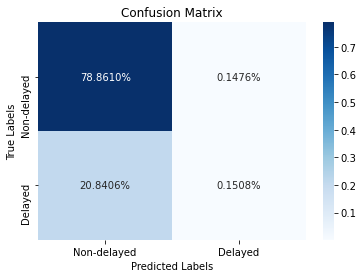

Linear Learner V1
Accuracy: 0.7901181227530998
f1 score: 0.014167560116403738
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88    193838
         1.0       0.51      0.01      0.01     51500

    accuracy                           0.79    245338
   macro avg       0.65      0.50      0.45    245338
weighted avg       0.73      0.79      0.70    245338



In [17]:
# Confusion Matrix.
plot_confusion_matrix(y_true_v1, y_pred_ll_v1)

# Results.
result_summary(y_true_v1, y_pred_ll_v1, header='Linear Learner V1')

### combined_csv_v2.csv

In [18]:
# Create classifier for data v2.
clf_ll_v2 = Estimator(
    ll_container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path='s3://{}/{}/output'.format(bucket, prefix)
)

# Set hyperparameters.
clf_ll_v2.set_hyperparameters(
    predictor_type='binary_classifier',
    mini_batch_size=10_000,
    epochs=3
)

In [19]:
# Train linear-learner for v2 dataset.
clf_ll_v2.fit(channels_v2)

2022-11-03 16:51:32 Starting - Starting the training job...
2022-11-03 16:51:54 Starting - Preparing the instances for trainingProfilerReport-1667494291: InProgress
......
2022-11-03 16:52:56 Downloading - Downloading input data......
2022-11-03 16:53:43 Training - Downloading the training image.....Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/03/2022 16:54:44 INFO 140596201035584] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1.0', 'quantile': '0.5', 'loss_

In [20]:
# Batch transform for linear learner on v2 dataset.

# Instantiate the transformer.
# Host the model on another instance.
transformer_ll_v2 = clf_ll_v2.transformer(
    instance_count=1,
    instance_type='ml.c5.9xlarge',
    strategy='MultiRecord',
    assemble_with='Line',
    output_path=batch_output_path_ll
)

# Perform batch transform on the testing data.
transformer_ll_v2.transform(
    data=X_test_v2_path,
    data_type='S3Prefix',
    content_type='text/csv',
    split_type='Line'
)

transformer_ll_v2.wait()

...................................
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2022 17:02:36 INFO 139913857156928] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2022 17:02:36 INFO 139913857156928] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
[11/03/2022 17:02:38 WARNING 139913857156928] Loggers have already been setup.
[11/03/2022 17:02:38 INFO 139913857156928] loaded entry point class algorithm.serve.server_config:config_api
[11/03/2022 17:02:38 INFO 139913857156928] loading entry points
[11/03/2022 17:02:38 INFO 139913857156928] loaded request iterator application/json
[11/03/2022 17:02:38 INFO 139913857156928] loaded request iterator application/jsonlines
[11/03/2022 17:02:38 INFO 139913857156928] loaded request iterator application/x-recordio-protobuf
[11/03

In [21]:
# Get the result.
batch_object = s3.get_object(Bucket=bucket, Key="{}/batch_out_ll/{}".format(prefix,'batch_v2.csv.out'))
y_pred_ll_v2 = pd.read_csv(io.BytesIO(batch_object['Body'].read()), ',', names=['target'])

# Store to csv.
y_pred_ll_v2.to_csv('prediction_ll_v2.csv')

# Convert to numpy.
y_pred_ll_v2 = get_ll_prediction(y_pred_ll_v2)

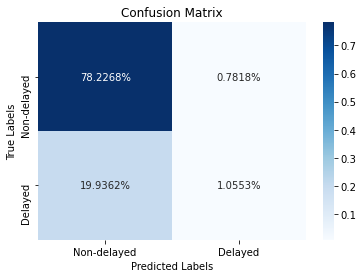

Linear Learner V2
Accuracy: 0.7928205170010353
f1 score: 0.09245272912314531
              precision    recall  f1-score   support

         0.0       0.80      0.99      0.88    193838
         1.0       0.57      0.05      0.09     51500

    accuracy                           0.79    245338
   macro avg       0.69      0.52      0.49    245338
weighted avg       0.75      0.79      0.72    245338



In [22]:
# Confusion Matrix.
plot_confusion_matrix(y_true_v2, y_pred_ll_v2)

# Results.
result_summary(y_true_v2, y_pred_ll_v2, header='Linear Learner V2')

## Comparison with the Scikit-learn onpremise training
Training and evaluating the results from SageMaker services and the model training and deployment in the onpremises.ipynb file, we can evaluate the pros and cons of both pipelines. There are some subtle differences in terms of the final model; however, the training methodologies were widely different from each other.

The main difference between onpremises.ipynb and oncloud.ipynb is where the actual training takes place. While onpremises.ipynb took place on my machine, oncloud.ipynb training was completed on servers or virtual machines provided by AWS. Firstly, the main script and the dataset were running on a machine called ml.t3.large, one of AWS's primary computing services. Our model training took place on a different virtual machine, the ml.m5.large, and finally, the model was deployed on ml.c5.9xlarge for evaluation using the testing set.

Because the onpremises.ipynb took place within the same computer, it was faster than the SageMaker pipeline. Running on different machines will have many overheads, such as instantiation of the virtual machine and network management to run the connection. Training and evaluating logistic regression on my computer was much faster than setting up the SageMaker estimator and batch transform.

Another challenge I found when training on SageMaker is that sometimes the internet connection or data could get corrupted during upload or download. When I was uploading the CSV files, frequently, the CSV files were not uploaded correctly, which caused the data to have missing values at specific rows and columns. I had to try multiple attempts to upload the CSV files. The same goes for downloading, where I had to download this file several times to ensure that it was updated and complete. There are download attempts that failed without giving a hard error, which I did not realise until I opened the .ipynb file locally and noticed that it was missing some cells and output. We will not encounter similar problems when working locally.

A positive feature of the SageMaker estimator is that it will try to hyper-parameter-tune our model and minimise (or maximise) the metrics we chose with the validation set. For example, in the 3.4 and 3.5 tutorials with the housing dataset, the SageMaker estimator tried to minimise the RMSE of the predictors. Our above SageMaker estimator was trying to get the best predictor with several metrics, such as cross-entropy, accuracy, and f1 scores. However, we must consider that Scikit-learn provides similar packages to perform hyper-parameter-tuning, such as the GridSearch module. We did not utilise those features on the onpremises.ipynb file.

There are pros and cons with onpremises.ipynb, and oncloud.ipynb files, and we need to understand the use cases. I think the cloud could be the solution for someone who does not have a good computer going into the world of data science. It is better to train the model with the available machines if we have competent machines and then deploy the trained model to the cloud.

## Comparison between oncloud V1 and V2 performances
Although not by much, the model trained on the second dataset is better than the model trained on the original features. The overall metric, the f1 score, is 0.0142 on V1 and 0.0925 on V2, which indicates that the V2 model performance is better than the V1 model. The precision of the positive class is slightly better on V2, which is 0.57 compared to 0.51 on V1. We also can see that the sensitivity is 0.01 on V1 and 0.05 on the V2 dataset. Therefore, the model trained on V2 is much better than the prior model since, in every metric that matters, such as overall f1 score, positive class precision, and sensitivity, the metrics are better in the V2 dataset.

## Comparison between oncloud and onpremises performances
There are two models, one trained on V1 and the other on V2. Please note that the SageMaker estimator had a hyper-parameter-tuning functionality when training. Scikit-learn also provides us with modules that perform hyper-parameter-tuning; however, we did not utilise those packages.

### V1 model
The differences between onpremises and oncloud for V1 are very subtle. As we can observe from the confusion matrix, the percentage of true positives is more prominent in the SageMaker estimator than our results from onpremises. There is a substantial gap between the f1 scores, where onpremises scored 0.0056 and oncloud scored 0.1417. However, the positive class precision is higher on the onpremises, by a precision of 0.6 to 0.51. The recall score of the onpremises is approaching zero, while the oncloud version is at 0.1. Because of the results, we know that the SageMaker estimator is better than the onpremises model.

### V2 model
Similarly to the V1 models, the difference between the V2 models is very close. The f1 scores are at 0.0815 for the onpremises model and 0.0925 for the oncloud; thus, the results imparity is insignificant. The significant difference is within the precision, where the SageMaker estimator scored 0.57, and the onpremises model scored 0.48, which made the prior model superior to the onpremises classifier.

### Conclusion
Although there are some differences, none of the differences shows a significant improvement over the other. The models oncloud are slightly better than the models trained on-premise. Due to the class imbalance, none of the models is usable for business usage unless we change the business requirements.

# Step 3: Build and evaluate ensembe models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use xgboost estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 
6. write down your observation on the difference between the performance of using the simple and ensemble models.
Note: You are required to perform the above steps on the two combined datasets separatey.

In [23]:
# Collections for step 3.

# Get XGBoost.
xgb_container = retrieve(framework='xgboost', region=region, version='1.0-1')

# Path for batch outputs.
batch_output_path_xgb = 's3://{}/{}/batch_out_xgb/'.format(bucket, prefix)
print(f'Batch output path: {batch_output_path_xgb}')

Batch output path: s3://sagemaker-us-east-1-669452603953/dsts-final-assignment/batch_out_xgb/


### combined_csv_v1.csv

In [24]:
# Create classifier for data v1.
clf_xgb_v1 = Estimator(
    xgb_container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path='s3://{}/{}/output'.format(bucket, prefix)
)

# Set hyperparameters.
clf_xgb_v1.set_hyperparameters(
    objective='multi:softmax',
    num_class='2',
    num_round=15,
    early_stopping_rounds=5
)

In [25]:
# Train XGBoost for v1 dataset.
clf_xgb_v1.fit(channels_v1)

2022-11-03 17:03:09 Starting - Starting the training job...
2022-11-03 17:03:35 Starting - Preparing the instances for trainingProfilerReport-1667494989: InProgress
.........
2022-11-03 17:04:55 Downloading - Downloading input data......
2022-11-03 17:06:06 Training - Downloading the training image......
2022-11-03 17:06:56 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[17:06:57] 1144913x93 matrix with 106476909 entries loaded from /opt/ml/input/data/train?f

In [26]:
# Batch transform for XGBoost on v1 dataset.

# Instantiate the transformer.
# Host the model on another instance.
transformer_xgb_v1 = clf_xgb_v1.transformer(
    instance_count=1,
    instance_type='ml.c5.9xlarge',
    strategy='MultiRecord',
    assemble_with='Line',
    output_path=batch_output_path_xgb
)

# Perform batch transform on the testing data.
transformer_xgb_v1.transform(
    data=X_test_v1_path,
    data_type='S3Prefix',
    content_type='text/csv',
    split_type='Line'
)

transformer_xgb_v1.wait()

..................................[2022-11-03:17:13:56:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-03:17:13:56:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-03:17:13:56:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2022-11-03 17:13:56 +0000] [82] [INFO] Starting g

In [27]:
# Get the result.
batch_object = s3.get_object(Bucket=bucket, Key="{}/batch_out_xgb/{}".format(prefix,'batch_v1.csv.out'))
y_pred_xgb_v1 = pd.read_csv(io.BytesIO(batch_object['Body'].read()), ',', names=['target'])

# Store to csv.
y_pred_xgb_v1.to_csv('prediction_xgb_v1.csv')

# Convert to numpy.
y_pred_xgb_v1 = y_pred_xgb_v1.to_numpy()

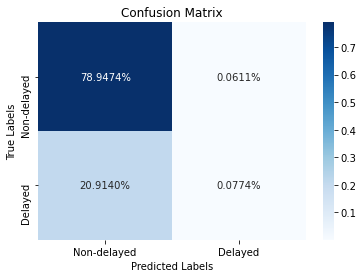

XGBoost V1
Accuracy: 0.7902485550546593
f1 score: 0.007330246913580247
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88    193838
         1.0       0.56      0.00      0.01     51500

    accuracy                           0.79    245338
   macro avg       0.67      0.50      0.45    245338
weighted avg       0.74      0.79      0.70    245338



In [28]:
# Confusion Matrix.
plot_confusion_matrix(y_true_v1, y_pred_xgb_v1)

# Results.
result_summary(y_true_v1, y_pred_xgb_v1, header='XGBoost V1')

### combined_csv_v2.csv

In [29]:
# Create classifier for data v2.
clf_xgb_v2 = Estimator(
    xgb_container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path='s3://{}/{}/output'.format(bucket, prefix)
)

# Set hyperparameters.
clf_xgb_v2.set_hyperparameters(
    objective='multi:softmax',
    num_class='2',
    num_round=15,
    early_stopping_rounds=5
)

In [30]:
# Train XGBoost for v1 dataset.
clf_xgb_v2.fit(channels_v2)

2022-11-03 17:14:47 Starting - Starting the training job...
2022-11-03 17:15:11 Starting - Preparing the instances for trainingProfilerReport-1667495686: InProgress
......
2022-11-03 17:16:16 Downloading - Downloading input data......
2022-11-03 17:17:12 Training - Downloading the training image...
2022-11-03 17:17:32 Training - Training image download completed. Training in progress...INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[17:17:39] 1144913x85 matrix with 97317605 entries loaded from /opt/ml/input/data/train?format

In [31]:
# Batch transform for XGBoost on v2 dataset.

# Instantiate the transformer.
# Host the model on another instance.
transformer_xgb_v2 = clf_xgb_v2.transformer(
    instance_count=1,
    instance_type='ml.c5.9xlarge',
    strategy='MultiRecord',
    assemble_with='Line',
    output_path=batch_output_path_xgb
)

# Perform batch transform on the testing data.
transformer_xgb_v2.transform(
    data=X_test_v2_path,
    data_type='S3Prefix',
    content_type='text/csv',
    split_type='Line'
)

transformer_xgb_v2.wait()

............................[2022-11-03:17:25:06:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-03:17:25:06:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-03:17:25:06:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2022-11-03 17:25:06 +0000] [82] [INFO] Starting gunicor

In [32]:
# Get the result.
batch_object = s3.get_object(Bucket=bucket, Key="{}/batch_out_xgb/{}".format(prefix,'batch_v2.csv.out'))
y_pred_xgb_v2 = pd.read_csv(io.BytesIO(batch_object['Body'].read()), ',', names=['target'])

# Store to csv.
y_pred_xgb_v2.to_csv('prediction_xgb_v2.csv')

# Convert to numpy.
y_pred_xgb_v2 = y_pred_xgb_v2.to_numpy()

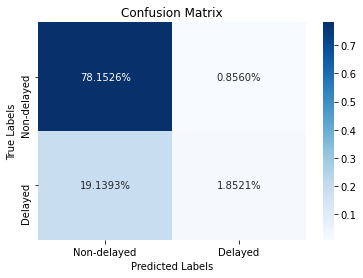

XGBoost V2
Accuracy: 0.8000472817093153
f1 score: 0.15630159603742433
              precision    recall  f1-score   support

         0.0       0.80      0.99      0.89    193838
         1.0       0.68      0.09      0.16     51500

    accuracy                           0.80    245338
   macro avg       0.74      0.54      0.52    245338
weighted avg       0.78      0.80      0.73    245338



In [33]:
# Confusion Matrix.
plot_confusion_matrix(y_true_v2, y_pred_xgb_v2)

# Results.
result_summary(y_true_v2, y_pred_xgb_v2, header='XGBoost V2')

In [34]:
# Empty cell.

## Introduction
We only compared the linear model performance with the XGBoost performances in this analysis. XGBoost is an ensemble method that utilises boosted decision trees. XGBoost methods are very similar to a gradient boost with optimised parameters. Since we have V1 and V2, I will break down the results into two sections that describe the two datasets and one conclusion that picks the best model overall.

## V1 Models
The f1 scores of the two models have significant differences, with 0.0142 for the linear model and 0.0073 on the XGBoost. We can also see that the true positives produced by the linear model are more significant than the XGBoost model. However, the precision of the XGBoost model is slightly higher than the linear model. Based on the results, we know that the linear model is less biased towards the majority class by sacrificing its precision. Depending on the scenario in the real world, the precision score could be detrimental, as we discussed previously in the onpremises.ipynb file.

## V2 Models
The XGBoost trained on the V2 has the highest f1 score amongst the oncloud models. The model scored a 0.1563 f1 score compared to its counterpart, which only achieved a 0.0925 f1 score. The XGBoost model also improves the positive class precision and sensitivity if we compare them to the linear model. Since all critical metrics are improved in the XGBoost model, we can conclude that the XGBoost model is better than the linear learner.

## Conclusion
The results are interesting because, on the V1 dataset, the linear learner performs better, but XGBoost is the superior model to the V2 dataset. If we compare every model objectively, the XGBoost on the V2 dataset is the best model that SageMaker created in this project. Although the f1 score is lower than some of the models we created onpremises, the last XGBoost model has the highest precision score compared to all models we created in this project.